In [75]:
import json
import threading
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.preprocessing import MultiLabelBinarizer

from keras.callbacks import ModelCheckpoint   
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, GlobalAveragePooling2D, GlobalMaxPooling2D, MaxPooling2D

DATA_DIR = "../data/"

In [59]:
with open(DATA_DIR + "train.json") as train, open(DATA_DIR + "test.json") as test, open(DATA_DIR + "validation.json") as validation:
    train_json = json.load(train)
    test_json = json.load(test)
    validation_json = json.load(validation)

def set_image_filename(row, image_set):
    """
    Function that returns properly annotated image filename path from dataframe row
    Format: id_{imageId}_labels_{labelId}
    Returns: true image path
    """
    labels = [int(x) for x in row['labelId']]
    true_image_path = DATA_DIR + "{}/id_{}_labels_{}.jpg".format(image_set, row['imageId'], labels)
    return true_image_path
    
def load_images(json_file, image_set):
    """
    Function to load, merge and correctly path all images for a given set
    Returns: dataframe
    """
    images_df = pd.DataFrame(json_file['images'])
    if image_set == 'test':
        images_df['imagePath'] = images_df['imageId'].map(lambda x: DATA_DIR + "{}/{}.jpg".format(image_set, x))
        return images_df
    else:
        annotations_df = pd.DataFrame(json_file['annotations'])
        merged = pd.merge(images_df, annotations_df, on='imageId', how='inner')
        merged['imagePath'] = merged.apply(lambda row: set_image_filename(row, image_set), axis=1)
        return merged
        
train_df = load_images(train_json, "train")
test_df = load_images(test_json, "test")
validation_df = load_images(validation_json, "validation")

In [60]:
mlb = MultiLabelBinarizer()
train_labels_np = mlb.fit_transform(train_df['labelId'])
train_labels = pd.DataFrame(data = train_labels_np, columns = list(mlb.classes_))

validation_labels_np = mlb.transform(validation_df['labelId'])
validation_labels = pd.DataFrame(data = validation_labels_np, columns = list(mlb.classes_))

In [61]:
print(train_df.shape)
train_df.head()

(1014544, 4)


,imageId,url,labelId,imagePath
0,1,https://contestimg.wish.com/api/webimage/570f3...,"[95, 66, 137, 70, 20]","../data/train/id_1_labels_[95, 66, 137, 70, 20..."
1,2,https://contestimg.wish.com/api/webimage/5468f...,"[36, 66, 44, 214, 105, 133]","../data/train/id_2_labels_[36, 66, 44, 214, 10..."
2,3,https://contestimg.wish.com/api/webimage/54641...,"[170, 66, 97, 153, 105, 138]","../data/train/id_3_labels_[170, 66, 97, 153, 1..."
3,4,https://contestimg.wish.com/api/webimage/550b9...,"[18, 66, 44, 153, 164]","../data/train/id_4_labels_[18, 66, 44, 153, 16..."
4,5,https://contestimg.wish.com/api/webimage/54451...,"[189, 66, 176, 137, 153, 74, 181, 171, 138]","../data/train/id_5_labels_[189, 66, 176, 137, ..."


In [62]:
print(train_labels.shape)
train_labels.head()

(1014544, 228)


,1,10,100,101,102,103,104,105,106,107,...,90,91,92,93,94,95,96,97,98,99
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


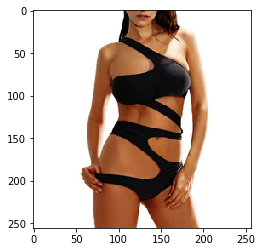

372749
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0]]
../data/train/id_372750_labels_[189, 17, 66, 176, 171].jpg


In [63]:
rand_img = np.random.randint(0, len(train_df.index))
target_size=(256,256)


img_label = np.array(train_labels.iloc[rand_img]).reshape(1, 228)
img_path = train_df.iloc[rand_img]['imagePath']
image = Image.open(img_path)
image_resized = image.resize(target_size, Image.ANTIALIAS)
image_resized.thumbnail(target_size, Image.ANTIALIAS)
plt.imshow(np.asarray(image_resized))
plt.show()
print(rand_img)
print(img_label)
print(img_path)

In [69]:
class BatchGenerator:
    def __init__(self, img_dataframe, label_dataframe, batch_size=32, target_size=(256,256)):
        self.img_dataframe = img_dataframe
        self.label_dataframe = label_dataframe
        self.batch_size = batch_size
        self.lock = threading.Lock()
        self.TARGET_SIZE=target_size
        
    def __iter__(self):
        return self
    
    def next(self):
        return self.__next__()
      
    def __next__(self):
        with self.lock:
            while True:
                X = []
                y = []
                for i in range(self.batch_size):
                    # get a random number
                    rand_img = np.random.randint(0, len(self.img_dataframe.index))
                    # get label from random number
                    img_label = np.array(self.label_dataframe.iloc[rand_img]).reshape(1, 228)
                    # get image path from random number
                    img_path = self.img_dataframe.iloc[rand_img]['imagePath']
                    # open image
                    image = Image.open(img_path)
                    # resize image
                    image_resized = image.resize(self.TARGET_SIZE, Image.ANTIALIAS)
                    # set image to thumbnail (proper scaling)
                    image_resized.thumbnail(self.TARGET_SIZE, Image.ANTIALIAS)                   
                    # cast image as np.array
                    X_batch = np.asarray(image_resized).reshape(1, 256, 256, 3)
                    # with proper datatype
                    X_batch = X_batch / 255.0
                    X.append(X_batch)
                    y.append(img_label)
                return np.array(X).reshape(self.batch_size, 256, 256, 3), np.array(y).reshape(self.batch_size, 228)           

train_gen = BatchGenerator(train_df, train_labels)
val_gen = BatchGenerator(validation_df, validation_labels)

In [80]:
EPOCHS = 10
STEPS = 250

model = Sequential()
model.add(Conv2D(filters=30, kernel_size=3, input_shape=(256, 256, 3)))
model.add(Dropout(0.4))
model.add(GlobalMaxPooling2D())
model.add(Dropout(0.3))
model.add(Dense(30, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(228, activation='softmax'))
print(model.output.shape)
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

checkpointer = ModelCheckpoint(
    filepath='model.best.hdf5', 
    verbose=1,
    save_best_only=True
)

model.fit_generator(
    train_gen, 
    epochs = EPOCHS,
    steps_per_epoch = STEPS,
    callbacks = [checkpointer],
    validation_data = val_gen,
    validation_steps = 1
)

(?, 228)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 254, 254, 30)      840       
_________________________________________________________________
dropout_16 (Dropout)         (None, 254, 254, 30)      0         
_________________________________________________________________
global_max_pooling2d_4 (Glob (None, 30)                0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 30)                930       
_________________________________________________________________
dropout_18 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 228)               7068      
T

KeyboardInterrupt: 